 Fee Investigation

 Uniswap charges flat fee structures in V3, either 1bp, 5bps, 30bps, or more. Uniswap V2 charged about 15bps. We are investigating how much we can shrink fees in times of lower volatility or smaller trades

In [1]:
import pandas as pd
import numpy as np
import requests

In [7]:
resp = requests.get('https://api.kraken.com/0/public/Depth?pair=ETHUSDC')

In [45]:
resp.status_code

200

In [21]:
data = resp.json()['result']['ETHUSDC']

In [26]:
asks = data['asks']
asks[:3][:3]

[['3682.980000', '0.009', 1710588935],
 ['3683.310000', '1.075', 1710588935],
 ['3683.720000', '0.549', 1710588935]]

In [27]:
bids = data['bids']
bids[:3][:3]

[['3682.630000', '0.549', 1710588936],
 ['3682.420000', '1.358', 1710588936],
 ['3681.700000', '0.650', 1710588935]]

In [33]:
asks[0][0]

'3682.980000'

In [34]:
spread = float(asks[0][0])-float(bids[0][0])

In [35]:
spread

0.34999999999990905

In [99]:
def get_vol()->float:
    oracle_realized_vol = 18446744073709559613
    return oracle_realized_vol*1e-18

def get_market_price()->float:
    return 3702

def get_trade_price()->float:
    return 3701

def get_trade_volume()->float:
    return 0.5

def get_is_buyer()-> bool:
    'Is the trader a buyer (True) or a seller (False)'
    return True

def get_trade_reduces_gap()->bool:
    'Returns if someone is trading against us to bring us closer to market price'
    # 
    return ((get_trade_price() > get_market_price()) ^ get_is_buyer())

ETH_PRICE = 3700

If our price > market price, a seller would move us closer to market price, get_trade_reduces_gap() is false
If our price < market price, a seller would move us further from market price, get_trade_reduces_gap() is true

In [138]:
def get_fee(volume: float,volatility: float,trade_reduces_gap: bool)->float:
    volume_factor = 0.5
    volatility_factor = 1/365
    trade_reduces_gap_factor = 1
    min_fee = 0.05
    fee = min_fee+(volume_factor*np.power(volume,1.5))*(volatility_factor*np.power(volatility,2))
    # We reduce the fee for when trades bring us further from market because those tend to be more uninformed traders
    if not trade_reduces_gap:
        fee *= trade_reduces_gap_factor
    return fee

In [139]:
get_fee(get_trade_volume(), get_vol(), get_trade_reduces_gap())

0.21480545833424985

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

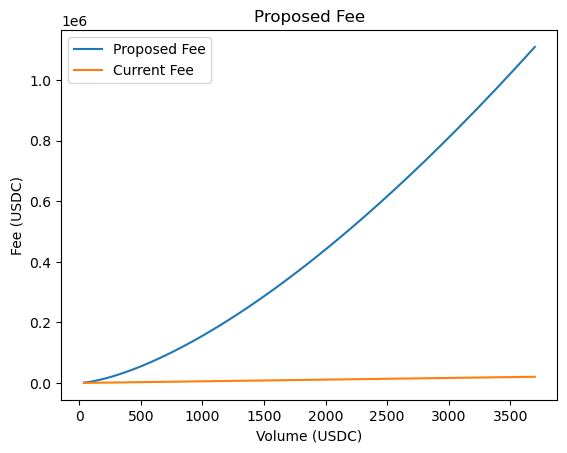

In [141]:
# x is volume
x = np.geomspace(0.01, 1, 100)*ETH_PRICE
proposed_fee = get_fee(x,60,True)
current_fee = get_current_fee(x)

plt.plot(x, proposed_fee, label='Proposed Fee')
plt.plot(x, current_fee, label='Current Fee')

# Add labels and title
plt.xlabel('Volume (USDC)')
plt.ylabel('Fee (USDC)')
plt.title('Proposed Fee')
plt.legend()

# Show the plot
plt.show()


In [142]:
proposed_fee

array([   1109.94584799,    1190.15493765,    1276.16051539,
          1368.38147732,    1467.26699198,    1573.29868807,
          1686.99300029,    1808.90368461,    1939.62451542,
          2079.79217753,    2230.0893672 ,    2391.24811724,
          2564.05336245,    2749.34676268,    2948.0308022 ,
          3161.07318532,    3389.51154963,    3634.45851993,
          3897.10712732,    4178.73661992,    4480.7186936 ,
          4804.52417283,    5151.73017452,    5524.02778942,
          5923.23031871,    6351.28210581,    6810.26800644,
          7302.42354305,    7830.14579309,    8396.00506413,
          9002.75741274,    9653.35806803,   10350.97582531,
         11099.00847994,   11901.09937649,   12761.15515394,
         13683.3647732 ,   14672.21991975,   15732.53688071,
         16869.4800029 ,   18088.5868461 ,   19395.7951542 ,
         20797.47177532,   22300.443672  ,   23912.03117241,
         25640.0836245 ,   27493.0176268 ,   29479.858022  ,
         31610.28185315,

In [143]:
current_fee

array([  205.35      ,   215.12789484,   225.37137149,   236.102599  ,
         247.34480199,   259.12231094,   271.46061484,   284.38641637,
         297.92768966,   312.11374088,   326.97527161,   342.54444531,
         358.85495694,   375.94210586,   393.84287223,   412.59599708,
         432.24206608,   452.82359744,   474.38513391,   496.97333918,
         520.63709884,   545.42762623,   571.39857324,   598.60614645,
         627.10922874,   656.96950675,   688.25160437,   721.02322262,
         755.35528615,   791.32209672,   829.00149405,   868.47502426,
         909.82811631,   953.15026698,   998.53523447,  1046.08124134,
        1095.89118713,  1148.07287098,  1202.73922499,  1260.0085586 ,
        1320.00481463,  1382.85783757,  1448.70365451,  1517.68476958,
        1589.95047239,  1665.65716103,  1744.96868064,  1828.05667796,
        1915.10097282,  2006.28994731,  2101.82095347,  2201.9007404 ,
        2306.74590172,  2416.58334433,  2531.65077944,  2652.19723711,
      

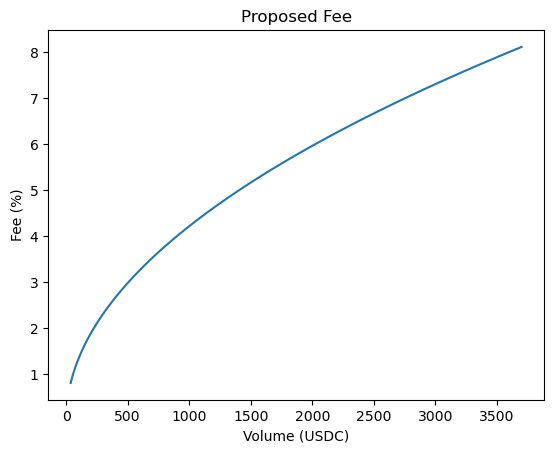

In [144]:
# x is volume
x = np.geomspace(0.01, 1, 100)*ETH_PRICE
# y is volatility
fee = get_fee(x,60,True)
z = get_percentage_fee(fee, x)

plt.plot(x, z)

# Add labels and title
plt.xlabel('Volume (USDC)')
plt.ylabel('Fee (%)')
plt.title('Proposed Fee')

# Show the plot
plt.show()


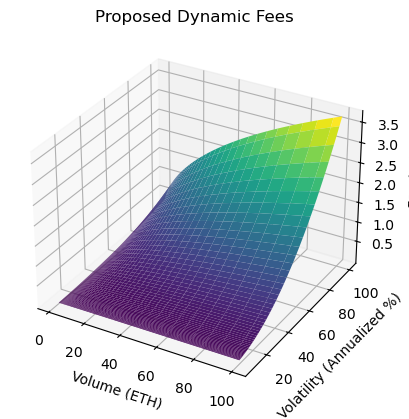

In [145]:
# x is volume
x = np.geomspace(1, 100, 100)
# y is volatility
y = np.geomspace(8, 100, 100)
x, y = np.meshgrid(x, y)
fee = get_fee(x,y,True)
z = get_percentage_fee(fee, x)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (%)')
ax.set_title('Proposed Dynamic Fees')

plt.show()


In [146]:
def get_current_fee(volume: float):
    return volume*3700*0.15/100

In [147]:
def get_percentage_fee(fee,volume):
    global ETH_PRICE
    return 100*fee/(volume*ETH_PRICE)

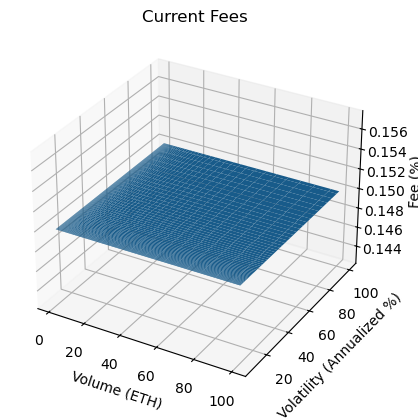

In [149]:
# x is volume
x = np.geomspace(1, 100, 100)
# y is volatility
y = np.geomspace(8, 100, 100)
x, y = np.meshgrid(x, y)
fee = get_current_fee(x)
z = get_percentage_fee(fee, x)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (%)')
ax.set_title('Current Fees')

plt.show()


In [155]:
price = (float(asks[0][0])-float(bids[0][0]))/2+float(bids[0][0])

In [156]:
price

3682.8050000000003

In [165]:
test_asks = np.array(asks).astype(np.float64)

In [224]:
test_bids = np.array(bids).astype(np.float64)

In [185]:
cum_volume = np.cumsum(test_asks[:,1]).reshape(-1,1)

In [225]:
cum_volume_bids = np.cumsum(test_bids[:,1]).reshape(-1,1)

In [226]:
test_bids_final = np.append(test_bids, cum_volume_bids, axis=1)

In [206]:
test_asks_final = np.append(test_asks, cum_volume, axis=1)

In [210]:
test_asks_final[:,0] = test_asks_final[:,0]-price

In [227]:
test_bids_final[:,0] = price-test_bids_final[:,0]

In [228]:
test_bids_final

array([[1.75000000e-01, 5.49000000e-01, 1.71058894e+09, 5.49000000e-01],
       [3.85000000e-01, 1.35800000e+00, 1.71058894e+09, 1.90700000e+00],
       [1.10500000e+00, 6.50000000e-01, 1.71058894e+09, 2.55700000e+00],
       [1.12500000e+00, 5.49000000e-01, 1.71058894e+09, 3.10600000e+00],
       [1.13500000e+00, 6.79100000e+00, 1.71058894e+09, 9.89700000e+00],
       [1.26500000e+00, 9.04000000e-01, 1.71058894e+09, 1.08010000e+01],
       [1.47500000e+00, 2.08000000e-01, 1.71058894e+09, 1.10090000e+01],
       [2.13500000e+00, 5.49000000e-01, 1.71058891e+09, 1.15580000e+01],
       [2.20500000e+00, 6.50000000e-01, 1.71058894e+09, 1.22080000e+01],
       [2.74500000e+00, 5.49000000e-01, 1.71058891e+09, 1.27570000e+01],
       [3.29500000e+00, 2.71000000e-01, 1.71058894e+09, 1.30280000e+01],
       [3.30500000e+00, 6.50000000e-01, 1.71058893e+09, 1.36780000e+01],
       [3.33500000e+00, 4.71000000e-01, 1.71058892e+09, 1.41490000e+01],
       [3.46500000e+00, 6.79500000e+00, 1.71058893e

In [ ]:
mod_asks

In [151]:
bids

[['3682.630000', '0.549', 1710588936],
 ['3682.420000', '1.358', 1710588936],
 ['3681.700000', '0.650', 1710588935],
 ['3681.680000', '0.549', 1710588935],
 ['3681.670000', '6.791', 1710588935],
 ['3681.540000', '0.904', 1710588935],
 ['3681.330000', '0.208', 1710588935],
 ['3680.670000', '0.549', 1710588911],
 ['3680.600000', '0.650', 1710588935],
 ['3680.060000', '0.549', 1710588909],
 ['3679.510000', '0.271', 1710588935],
 ['3679.500000', '0.650', 1710588933],
 ['3679.470000', '0.471', 1710588916],
 ['3679.340000', '6.795', 1710588933],
 ['3679.010000', '0.257', 1710588935],
 ['3679.000000', '0.425', 1710588925],
 ['3678.700000', '0.549', 1710588902],
 ['3678.600000', '0.012', 1710588933],
 ['3678.400000', '0.650', 1710588933],
 ['3678.060000', '12.788', 1710588930],
 ['3678.050000', '3.962', 1710588923],
 ['3678.000000', '0.451', 1710588912],
 ['3677.580000', '0.549', 1710588876],
 ['3677.300000', '0.650', 1710588935],
 ['3677.100000', '1.087', 1710588905],
 ['3677.070000', '0.549'

In [150]:
asks

[['3682.980000', '0.009', 1710588935],
 ['3683.310000', '1.075', 1710588935],
 ['3683.720000', '0.549', 1710588935],
 ['3683.990000', '6.787', 1710588935],
 ['3684.830000', '0.549', 1710588933],
 ['3685.000000', '0.650', 1710588934],
 ['3685.140000', '6.785', 1710588935],
 ['3685.410000', '0.220', 1710588935],
 ['3685.570000', '0.549', 1710588928],
 ['3685.630000', '3.810', 1710588935],
 ['3686.080000', '2.507', 1710588934],
 ['3686.090000', '3.962', 1710588929],
 ['3686.100000', '0.650', 1710588935],
 ['3686.240000', '0.549', 1710588912],
 ['3686.550000', '4.292', 1710588935],
 ['3686.700000', '0.549', 1710588573],
 ['3686.720000', '0.012', 1710588933],
 ['3686.760000', '7.495', 1710588933],
 ['3687.200000', '0.650', 1710588886],
 ['3687.310000', '0.454', 1710588933],
 ['3687.410000', '0.254', 1710588935],
 ['3687.420000', '0.549', 1710588934],
 ['3687.550000', '1.086', 1710588933],
 ['3687.630000', '6.780', 1710588934],
 ['3688.150000', '1.229', 1710588936],
 ['3688.160000', '0.549',

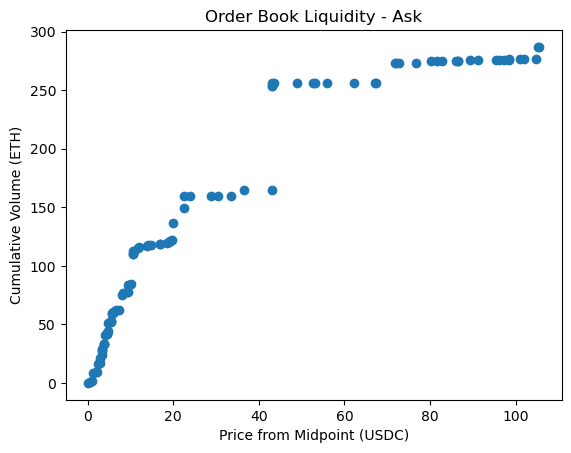

<Figure size 640x480 with 0 Axes>

In [215]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = test_asks_final[:,0]
y = test_asks_final[:,3]

ax.scatter(x, y)

# Set labels and title
ax.set_xlabel('Price from Midpoint (USDC)')
ax.set_ylabel('Cumulative Volume (ETH)')
ax.set_title('Order Book Liquidity - Ask')

plt.show()
plt.savefig('orderbook_liquidity_ask.png')

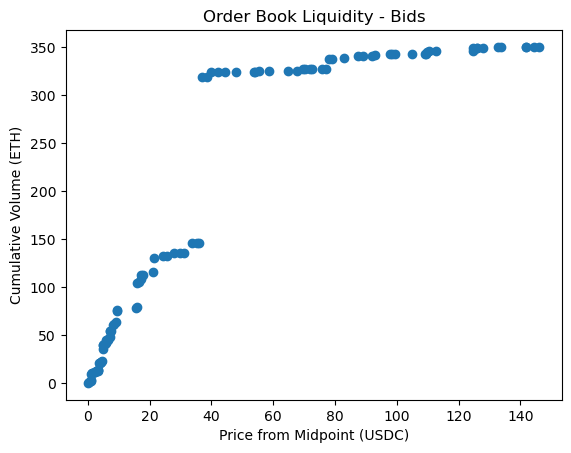

<Figure size 640x480 with 0 Axes>

In [230]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = test_bids_final[:,0]
y = test_bids_final[:,3]

ax.scatter(x, y)

# Set labels and title
ax.set_xlabel('Price from Midpoint (USDC)')
ax.set_ylabel('Cumulative Volume (ETH)')
ax.set_title('Order Book Liquidity - Bids')

plt.show()
plt.savefig('orderbook_liquidity_bid.png')